In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from nltk.corpus import wordnet

import random


In [2]:
# Set a random seed
random_seed = 42
random.seed(random_seed)

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df.shape

(7613, 5)

In [5]:
train_df.groupby(['target']).agg({'id' : 'nunique'}).reset_index()

,target,id
0,0,4342
1,1,3271


In [6]:
# Create new text column, adding keyword and location

train_df.keyword = train_df.keyword.fillna('')
train_df.location = train_df.location.fillna('')

train_df['text_conc'] = train_df.text + " " + train_df.keyword + " " + train_df.location


test_df.keyword = test_df.keyword.fillna('')
test_df.location = test_df.location.fillna('')

test_df['text_conc'] = test_df.text + " " + test_df.keyword + " " + test_df.location


In [7]:
# Do train and validation split 90-10 split)
n = round(len(train_df)*0.1)
valdn_split_df = train_df.sample(n, replace = False)
train_split_df = train_df[~(train_df.index.isin(valdn_split_df.index))]

train_split_df.shape, valdn_split_df.shape

((6852, 6), (761, 6))

# Data Augmentation - Making more data and more noise

## Introducing Noise

In [10]:
train_split_df['target_lead'] = train_split_df['target'].shift(-1)
train_split_df['text_conc_lead'] = train_split_df['text_conc'].shift(-1)

C:\Users\abhis\AppData\Local\Temp\ipykernel_25160\1512767502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_split_df['target_lead'] = train_split_df['target'].shift(-1)
C:\Users\abhis\AppData\Local\Temp\ipykernel_25160\1512767502.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_split_df['text_conc_lead'] = train_split_df['text_conc'].shift(-1)


In [11]:
train_split_df['text_conc_snth'] = train_split_df['text_conc'] + ' ' + train_split_df['text_conc_lead']
train_split_df['target_snth'] = train_split_df['target'] + train_split_df['target_lead']

train_split_df['target_snth'] = np.where(train_split_df['target_snth'] == 2, 1, train_split_df['target_snth'])

train_df_org = train_split_df[['text_conc', 'target']]
train_df_noise = train_split_df[['text_conc_snth', 'target_snth']]
train_df_noise = train_df_noise[train_df_noise['text_conc_snth'].notnull()]

train_df_noise.rename(columns = {'text_conc_snth' : 'text_conc', 'target_snth' : 'target'}, inplace = True)


C:\Users\abhis\AppData\Local\Temp\ipykernel_25160\1116068209.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_split_df['text_conc_snth'] = train_split_df['text_conc'] + ' ' + train_split_df['text_conc_lead']
C:\Users\abhis\AppData\Local\Temp\ipykernel_25160\1116068209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_split_df['target_snth'] = train_split_df['target'] + train_split_df['target_lead']
C:\Users\abhis\AppData\Local\Temp\ipykernel_25160\1116068209.py:4: SettingWithCopyWarning: 
A

## Making more Data

In [13]:

def combine_tweet_chunks(tweets, labels, num_augment=1000):
    augmented_tweets = []
    augmented_labels = []

    for _ in range(num_augment):
        # Randomly select two different tweets
        idx1, idx2 = random.sample(range(len(tweets)), 2)
        tweet1, tweet2 = tweets[idx1], tweets[idx2]
        label1, label2 = labels[idx1], labels[idx2]
        
        words1, words2 = tweet1.split(), tweet2.split()
        
        if len(words1) < 4 or len(words2) < 4:
            continue  # Skip very short tweets to avoid poor augmentation
        
        # Randomly select chunk sizes
        chunk_size1 = random.randint(2, len(words1) // 2)
        chunk_size2 = random.randint(2, len(words2) // 2)
        
        # Extract random chunks
        start1 = random.randint(0, len(words1) - chunk_size1)
        start2 = random.randint(0, len(words2) - chunk_size2)
        
        chunk1 = words1[start1:start1 + chunk_size1]
        chunk2 = words2[start2:start2 + chunk_size2]
        
        # Combine the chunks
        new_tweet = ' '.join(chunk1 + chunk2)
        
        # Assign label (majority sentiment or random selection)
        new_label = label1 if label1 == label2 else random.choice([label1, label2])
        
        augmented_tweets.append(new_tweet)
        augmented_labels.append(new_label)

    # Append new records to the existing dataset
    print(len(augmented_tweets))
    # tweets.extend(augmented_tweets)
    # labels = np.concatenate([labels, np.array(augmented_labels)])

    return_df = pd.DataFrame({
    'text_conc': augmented_tweets,
    'target': augmented_labels})

    return return_df



In [14]:
# Apply augmentation - target = 1
train_split_df_pos = train_split_df[train_split_df.target == 1]
train_split_df_neg = train_split_df[train_split_df.target == 0]

pos_training_new = combine_tweet_chunks(list(train_split_df_pos.text_conc), list(train_split_df_pos.target), num_augment=3000)  # Generates 3000 new records
neg_training_new = combine_tweet_chunks(list(train_split_df_neg.text_conc), list(train_split_df_neg.target), num_augment=3000)  # Generates 3000 new records


2999
2949


In [15]:
neg_training_new.shape

(2949, 2)

## Synonym Replacement

In [17]:

def synonym_replacement(text, n=2):
    words = text.split()
    new_words = words.copy()
    random_indices = random.sample(range(len(words)), min(n, len(words)))
    
    for i in random_indices:
        synonyms = wordnet.synsets(words[i])
        if synonyms:
            word_choices = [lemma.name() for syn in synonyms for lemma in syn.lemmas() if lemma.name() != words[i]]
            if word_choices:
                new_words[i] = random.choice(word_choices).replace("_", " ")  # Replace with synonym
                  
    new_tweet = ' '.join(new_words)
    
    return new_tweet


In [18]:

# Apply augmentation - target = 1
train_split_df_pos = train_split_df[train_split_df.target == 1]
train_split_df_neg = train_split_df[train_split_df.target == 0]

# Apply augmentation
syn_tweets_pos = [synonym_replacement(tweet_pos) for tweet_pos in list(train_split_df_pos.text_conc)]
syn_tweets_neg = [synonym_replacement(tweet_neg) for tweet_neg in list(train_split_df_neg.text_conc)]

syn_tweets_pos_df = pd.DataFrame({
    'text_conc': syn_tweets_pos,
    'target': 1})

syn_tweets_neg_df = pd.DataFrame({
    'text_conc': syn_tweets_neg,
    'target': 0})


In [19]:
syn_tweets_pos_df.shape, syn_tweets_neg_df.shape

((2960, 2), (3892, 2))

In [20]:
# Combine all the new data with the existing

train_df_mod = pd.concat([train_df_org, pos_training_new, neg_training_new, syn_tweets_pos_df, syn_tweets_neg_df, train_df_noise])


In [21]:
train_df_mod.shape, train_split_df.shape

((26503, 2), (6852, 10))

In [22]:
train_df_mod.groupby(['target']).agg({'text_conc' : 'nunique'}).reset_index()

,target,text_conc
0,0.0,13000
1,1.0,12793


## Finally, do lemmatization - Dropping this idea

In [24]:
# nltk.download('stopwords')
# nltk.download('wordnet')

# lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))

# def clean_text(text):
#     text = text.lower()  # Convert to lowercase
#     text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters & numbers
#     words = text.split()
#     words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Remove stopwords & lemmatize
#     return ' '.join(words)

# train_df_mod['text_conc_lem'] = [clean_text(tweet) for tweet in list(train_df_mod.text_conc)]
# valdn_split_df['text_conc_lem'] = [clean_text(tweet) for tweet in list(valdn_split_df.text_conc)]


## Augmentation Over - time to create tokens and pad them

In [26]:
# Create Tokens

training_tweets = np.array(train_df_mod.text_conc)
valdn_tweets = np.array(valdn_split_df.text_conc)
test_tweets = np.array(test_df.text_conc)

tokenizer = Tokenizer(num_words=2000)

tokenizer.fit_on_texts(training_tweets)

training_tweets_token = tokenizer.texts_to_sequences(training_tweets)
valdn_tweets_token = tokenizer.texts_to_sequences(valdn_tweets)
test_tweets_token = tokenizer.texts_to_sequences(test_tweets)

len(training_tweets_token[0]), len(valdn_tweets_token[1]), len(test_tweets_token[1])

(10, 19, 7)

In [27]:
input_dimension_size = max(len(seqn) for seqn in training_tweets_token)
input_dimension_size_valdn = max(len(seqn) for seqn in valdn_tweets_token)
input_dimension_size_test = max(len(seqn) for seqn in test_tweets_token)

embedding_input_dimension = 2001

In [28]:
# # Do Padding

# Padding
X_train = sequence.pad_sequences(training_tweets_token, maxlen=input_dimension_size)
X_val = sequence.pad_sequences(valdn_tweets_token, maxlen=input_dimension_size_valdn)
X_test = sequence.pad_sequences(test_tweets_token, maxlen=input_dimension_size_test)


In [29]:
# Try BERT, GPT - done
# Try data augmentation - chop up tweets and make more data
# Try adding noise - mixing two tweets - done, but try more
# Add stemming and lemmatization
# Try word2vec - done
# Try ensembling


In [30]:
input_dimension_size

59

## Standard Models?

## Bidirectional stacked GRU model

In [33]:
# Build model 1

model_bid_gru = keras.Sequential()
model_bid_gru.add(layers.Input((input_dimension_size,)))
model_bid_gru.add(layers.Embedding(embedding_input_dimension, 32))
model_bid_gru.add(layers.Bidirectional(layers.GRU(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)))
model_bid_gru.add(layers.LayerNormalization())
model_bid_gru.add(layers.Bidirectional(layers.GRU(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model_bid_gru.add(layers.LayerNormalization())
model_bid_gru.add(layers.Bidirectional(layers.GRU(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)))
model_bid_gru.add(layers.LayerNormalization())
model_bid_gru.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam(learning_rate=0.0001)

model_bid_gru.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model_bid_gru.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 59, 32)         │        64,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 59, 256)        │       124,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 59, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 59, 256)        │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 59, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 256)            │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 783,137 (2.99 MB)

 Trainable params: 783,137 (2.99 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Fit model

y_train = np.array(train_df_mod.target)
# y_train = np.array(train_df.target)
y_val = np.array(valdn_split_df['target'])

EPOCHS = 32
BATCH = 1024

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


model_bid_gru.fit(X_train, y_train,
          batch_size=BATCH,
          epochs=EPOCHS,
          # validation_split=0.2,
          validation_data=(X_val, y_val),
          verbose = 1,
          callbacks = [early_stop])

# final validation accuracy - regular embedding - 0.7761

Epoch 1/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 254s 9s/step - accuracy: 0.5286 - loss: 0.7991 - val_accuracy: 0.6386 - val_loss: 0.6254
Epoch 2/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 193s 7s/step - accuracy: 0.6001 - loss: 0.6846 - val_accuracy: 0.6741 - val_loss: 0.5915
Epoch 3/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 231s 9s/step - accuracy: 0.6457 - loss: 0.6365 - val_accuracy: 0.7201 - val_loss: 0.5601
Epoch 4/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 216s 8s/step - accuracy: 0.6987 - loss: 0.5787 - val_accuracy: 0.7424 - val_loss: 0.5249
Epoch 5/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 208s 8s/step - accuracy: 0.7291 - loss: 0.5387 - val_accuracy: 0.7819 - val_loss: 0.4906
Epoch 6/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 186s 7s/step - accuracy: 0.7615 - loss: 0.4987 - val_accuracy: 0.7937 - val_loss: 0.4658
Epoch 7/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 197s 8s/step - accuracy: 0.7861 - loss: 0.4570 - val_accuracy: 0.7963 - val_loss: 0.4511
Epoch 8/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 216s 8s/step - accuracy: 0.8007 - loss: 0.4283 - val_accuracy: 0.8147 - v

## Stacked GRU model

In [64]:
# Build model 2

model_gru = keras.Sequential()
model_gru.add(layers.Input((input_dimension_size,)))
model_gru.add(layers.Embedding(embedding_input_dimension, 32))
model_gru.add(layers.GRU(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_gru.add(layers.LayerNormalization())
model_gru.add(layers.GRU(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model_gru.add(layers.LayerNormalization())
model_gru.add(layers.GRU(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))
model_gru.add(layers.LayerNormalization())
model_gru.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam(learning_rate=0.0001)

model_gru.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model_gru.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 59, 32)         │        64,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 59, 128)        │        62,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 59, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 59, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 59, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 325,281 (1.24 MB)

 Trainable params: 325,281 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# Fit model

y_train = np.array(train_df_mod.target)
# y_train = np.array(train_df.target)
y_val = np.array(valdn_split_df['target'])

EPOCHS = 32
BATCH = 1024

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


model_gru.fit(X_train, y_train,
          batch_size=BATCH,
          epochs=EPOCHS,
          # validation_split=0.2,        
          validation_data=(X_val, y_val),
          verbose = 1,
          callbacks = [early_stop])

# final validation accuracy - regular embedding - 0.7761

Epoch 1/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.5327 - loss: 0.8677 - val_accuracy: 0.6518 - val_loss: 0.6354
Epoch 2/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.5841 - loss: 0.7025 - val_accuracy: 0.6689 - val_loss: 0.6096
Epoch 3/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.6219 - loss: 0.6587 - val_accuracy: 0.6978 - val_loss: 0.5748
Epoch 4/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.6544 - loss: 0.6270 - val_accuracy: 0.7083 - val_loss: 0.5559
Epoch 5/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.6975 - loss: 0.5782 - val_accuracy: 0.7503 - val_loss: 0.5071
Epoch 6/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.7296 - loss: 0.5404 - val_accuracy: 0.7714 - val_loss: 0.4973
Epoch 7/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.7511 - loss: 0.5083 - val_accuracy: 0.7884 - val_loss: 0.4600
Epoch 8/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.7708 - loss: 0.4786 - val_accuracy: 0.8003 - val_loss:

## Bidirectional stacked LSTM model

In [66]:
# Build model 3

model_bid = keras.Sequential()
model_bid.add(layers.Input((input_dimension_size,)))
model_bid.add(layers.Embedding(embedding_input_dimension, 32))
model_bid.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)))
model_bid.add(layers.LayerNormalization())
model_bid.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model_bid.add(layers.LayerNormalization())
model_bid.add(layers.Bidirectional(layers.LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)))
model_bid.add(layers.LayerNormalization())
model_bid.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam(learning_rate=0.0001)

model_bid.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model_bid.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 59, 32)         │        64,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 59, 256)        │       164,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_6           │ (None, 59, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 59, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_7           │ (None, 59, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_8           │ (None, 256)            │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,019,169 (3.89 MB)

 Trainable params: 1,019,169 (3.89 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Fit model

y_train = np.array(train_df_mod.target)
# y_train = np.array(train_df.target)
y_val = np.array(valdn_split_df['target'])

EPOCHS = 40
BATCH = 1024

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


model_bid.fit(X_train, y_train,
          batch_size=BATCH,
          epochs=EPOCHS,
          # validation_split=0.2,
          validation_data=(X_val, y_val),
          verbose = 1,
          callbacks = [early_stop])


# final validation accuracy - regular embedding - 0.7846

Epoch 1/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 368s 12s/step - accuracy: 0.5298 - loss: 0.8329 - val_accuracy: 0.6202 - val_loss: 0.6422
Epoch 2/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 298s 11s/step - accuracy: 0.5885 - loss: 0.6950 - val_accuracy: 0.7004 - val_loss: 0.5579
Epoch 3/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 341s 13s/step - accuracy: 0.6408 - loss: 0.6420 - val_accuracy: 0.7214 - val_loss: 0.5127
Epoch 4/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 253s 10s/step - accuracy: 0.6964 - loss: 0.5831 - val_accuracy: 0.7753 - val_loss: 0.4753
Epoch 5/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 187s 7s/step - accuracy: 0.7421 - loss: 0.5220 - val_accuracy: 0.7911 - val_loss: 0.4603
Epoch 6/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 203s 8s/step - accuracy: 0.7640 - loss: 0.4872 - val_accuracy: 0.8160 - val_loss: 0.4259
Epoch 7/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 181s 7s/step - accuracy: 0.7820 - loss: 0.4594 - val_accuracy: 0.8160 - val_loss: 0.4276
Epoch 8/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 178s 7s/step - accuracy: 0.7996 - loss: 0.4308 - val_accuracy: 0.7976

## Stacked LSTM model

In [68]:
# Build model 4

model = keras.Sequential()
model.add(layers.Input((input_dimension_size,)))
model.add(layers.Embedding(embedding_input_dimension, 16))
model.add(layers.LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model.add(layers.LayerNormalization())
model.add(layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.LayerNormalization())
model.add(layers.LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))
model.add(layers.LayerNormalization())
model.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 59, 16)         │        32,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 59, 128)        │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_9           │ (None, 59, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 59, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_10          │ (None, 59, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_11          │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 370,321 (1.41 MB)

 Trainable params: 370,321 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Fit model

y_train = np.array(train_df_mod.target)
# y_train = np.array(train_df.target)
y_val = np.array(valdn_split_df['target'])

EPOCHS = 40
BATCH = 1024

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


model.fit(X_train, y_train,
          batch_size=BATCH,
          epochs=EPOCHS,
          # validation_split=0.1,
          validation_data=(X_val, y_val),
          verbose = 1,
          callbacks = [early_stop])


# final validation accuracy - regular embedding - 0.7913

Epoch 1/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5125 - loss: 0.8471 - val_accuracy: 0.6294 - val_loss: 0.6500
Epoch 2/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5711 - loss: 0.6995 - val_accuracy: 0.6715 - val_loss: 0.6162
Epoch 3/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.6067 - loss: 0.6651 - val_accuracy: 0.6846 - val_loss: 0.5928
Epoch 4/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6536 - loss: 0.6242 - val_accuracy: 0.7188 - val_loss: 0.5411
Epoch 5/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6891 - loss: 0.5856 - val_accuracy: 0.7424 - val_loss: 0.5013
Epoch 6/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7416 - loss: 0.5266 - val_accuracy: 0.7740 - val_loss: 0.4740
Epoch 7/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7637 - loss: 0.4953 - val_accuracy: 0.7976 - val_loss: 0.4474
Epoch 8/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7789 - loss: 0.4702 - val_accuracy: 0.7963 - val_loss:

## Ensemble it

In [76]:
_, acc_lstm = model.evaluate(X_val, y_val, batch_size=64, verbose = 0)
print("Validation set accuracy for Stacked LSTM: {:.2f}%".format(acc_lstm*100))

_, acc_lstm_bid = model_bid.evaluate(X_val, y_val, batch_size=64, verbose = 0)
print("Validation set accuracy for Stacked Bidirectional LSTM: {:.2f}%".format(acc_lstm_bid*100))

_, acc_gru = model_gru.evaluate(X_val, y_val, batch_size=64, verbose = 0)
print("Validation set accuracy for Stacked GRU: {:.2f}%".format(acc_gru*100))

_, acc_bid_gru = model_bid_gru.evaluate(X_val, y_val, batch_size=64, verbose = 0)
print("Validation set accuracy for Stacked Bidirectional GRU: {:.2f}%".format(acc_bid_gru*100))

Validation set accuracy for Stacked LSTM: 79.50%
Validation set accuracy for Stacked Bidirectional LSTM: 81.47%
Validation set accuracy for Stacked GRU: 82.13%
Validation set accuracy for Stacked Bidirectional GRU: 80.95%


In [105]:
valdn_split_df["predicted_target_lstm"] = model.predict(X_val)
valdn_split_df["predicted_target_bid_lstm"] = model_bid.predict(X_val)
valdn_split_df["predicted_target_gru"] = model_gru.predict(X_val)
valdn_split_df["predicted_target_bid_gru"] = model_bid_gru.predict(X_val)

valdn_split_df["final_predicted_target"] = (valdn_split_df["predicted_target_lstm"] + valdn_split_df["predicted_target_bid_lstm"] + 
                                            valdn_split_df["predicted_target_gru"] + valdn_split_df["predicted_target_bid_gru"])/4

valdn_split_df["target_pred"] =np.where(valdn_split_df["final_predicted_target"] >= 0.6, 1, 0)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


In [106]:
valdn_split_df.head()

,id,keyword,location,text,target,text_conc,predicted_target_lstm,predicted_target_bid_lstm,predicted_target_gru,predicted_target_bid_gru,final_predicted_target,target_pred
2825,4061,displaced,Seattle,The year is 2065 and the national society of m...,0,The year is 2065 and the national society of m...,0.640860,0.386874,0.621113,0.684293,0.583285,0
3813,5417,first%20responders,WorldWide,Loved the way this book was written to include...,0,Loved the way this book was written to include...,0.234910,0.105431,0.153549,0.074443,0.142083,0
4807,6843,loud%20bang,English Midlands,St steel coffee cafetiere exploded this am wit...,1,St steel coffee cafetiere exploded this am wit...,0.313803,0.094160,0.042719,0.054094,0.126194,0
7286,10427,whirlwind,Manchester,In @edfringe? We highly recommend @M00NF00L #T...,0,In @edfringe? We highly recommend @M00NF00L #T...,0.366181,0.344963,0.195017,0.075106,0.245317,0
3993,5672,floods,Michigan,Disaster group stunned by floods http://t.co/j...,1,Disaster group stunned by floods http://t.co/j...,0.994471,0.997422,0.998001,0.998685,0.997145,1


In [107]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1_score = tp / (tp+((fn+fp)/2))
    accuracy = (tp + tn)/(tp + tn + fp + fn)

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)) + " Accuracy - " + str(accuracy))

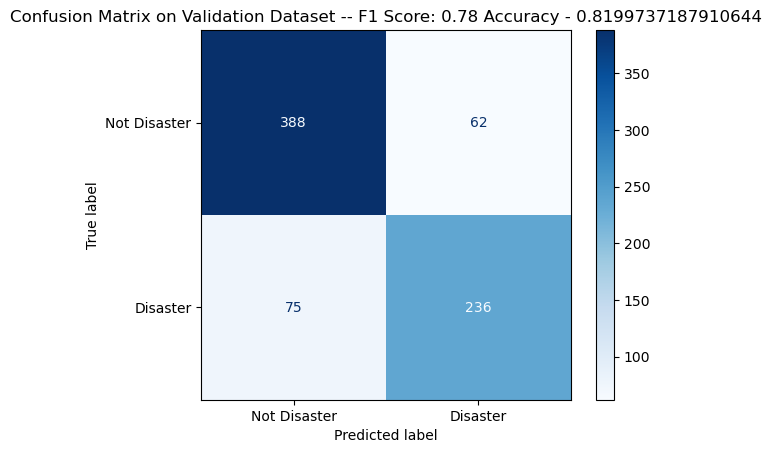

In [108]:
displayConfusionMatrix(np.array(valdn_split_df["target"]), np.array(valdn_split_df["target_pred"]), "Validation")

## Retrain and fit on full training data

In [81]:
# Read the submission file

sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [82]:
# Test on test data
sample_submission["predicted_target_lstm"] = model.predict(X_test)
sample_submission["predicted_target_bid_lstm"] = model_bid.predict(X_test)
sample_submission["predicted_target_gru"] = model_gru.predict(X_test)
sample_submission["predicted_target_bid_gru"] = model_bid_gru.predict(X_test)

sample_submission["target_prob"] = (sample_submission["predicted_target_lstm"] + sample_submission["predicted_target_bid_lstm"] + 
                                            sample_submission["predicted_target_gru"] + sample_submission["predicted_target_bid_gru"])/4

sample_submission["target"] =np.where(sample_submission["target_prob"] >= 0.6, 1, 0)

sample_submission = sample_submission[['id', 'target']]

102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step


In [83]:
sample_submission.head(3)

,id,target
0,0,1
1,2,1
2,3,1


In [84]:
sample_submission.target.unique()

array([1, 0])

In [95]:
sample_submission.to_csv('submission-ensemble_and_layer_normalization.csv', index = False)